## Importing Dependencies

In [1]:
import time    #for calculating time

#core packages
import numpy as np
import matplotlib.pyplot as plt

#custom module
from  dataset import load_dataset, train_dev_split, prep_dataset
from dataset import visualize_data_distribution, visualize_dataset

from ModelUtils import relu, relu_grad, softmax
from ModelUtils import rand_mini_batches, convert_time
from ModelUtils import confusion_matrix, plot_confusion_matrix, model_metrics, metric_summary
from ModelUtils import visualize_training_results, visualize_prediction, visualize_mislabelled_images
from ModelUtils import save_model, load_model


from imgaug import augment_img

# np.random.seed(1)
%matplotlib inline

## Dataset Preparation

### Loading Dataset

In [2]:
dataset_size_in_per = 100

train_x_orig, train_y_orig, test_x_orig, test_y_orig = load_dataset(dataset = "mnist", size_in_per = dataset_size_in_per)

print("Sample Size : %d%%\n"%(dataset_size_in_per))
print("Data\t\t\t","Datatype\t\t","Dataset Size")
print("=================================================================")
print("Training Set Images:\t" + str(type(train_x_orig))+"\t",str(train_x_orig.shape))
print("Training Set Labels:\t" + str(type(train_y_orig))+"\t",str(train_y_orig.shape))
print("Test Set Images:\t" + str(type(test_x_orig))+"\t",str(test_x_orig.shape))
print("Test Set Labels:\t" + str(type(test_y_orig))+"\t",str(test_y_orig.shape))
print("=================================================================")



Sample Size : 100%

Data			 Datatype		 Dataset Size
Training Set Images:	<class 'numpy.ndarray'>	 (60000, 28, 28)
Training Set Labels:	<class 'numpy.ndarray'>	 (60000, 1)
Test Set Images:	<class 'numpy.ndarray'>	 (10000, 28, 28)
Test Set Labels:	<class 'numpy.ndarray'>	 (10000, 1)


### Train-Dev set Split

In [3]:
train_x_split, train_y_split, dev_x_split, dev_y_split = train_dev_split(train_x_orig, train_y_orig)

print("Data\t\t\t\t","Datatype\t\t","Shape")
print("========================================================================")
print("Training Set Images:\t\t" + str(type(train_x_split))+"\t",str(train_x_split.shape))
print("Training Set Labels:\t\t" + str(type(train_y_split))+"\t",str(train_y_split.shape))
print("Development Set Images:\t\t" + str(type(dev_x_split))+"\t",str(dev_x_split.shape))
print("Development Set Labels:\t\t" + str(type(dev_y_split))+"\t",str(dev_y_split.shape))
print("========================================================================")


Data				 Datatype		 Shape
Training Set Images:		<class 'numpy.ndarray'>	 (50000, 28, 28)
Training Set Labels:		<class 'numpy.ndarray'>	 (50000, 1)
Development Set Images:		<class 'numpy.ndarray'>	 (10000, 28, 28)
Development Set Labels:		<class 'numpy.ndarray'>	 (10000, 1)


### Augmenting Dataset

In [4]:
def generate_minibatches(X, Y, minibatch_size=64, seed=1):
  
    np.random.seed(seed)  # varying the seed value so that the minibatchs become random in each epoch
    m = Y.shape[0]  # number of training examples
    minibatches = []

    # Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :, :]
    shuffled_Y = Y[permutation, :]

    # Partition (shuffled_X, shuffled_Y) except for the last batch
    num_complete_minibatches = np.floor(m / minibatch_size).astype(int)  # number of mini batches of size minibatch_size
    for k in range(0, num_complete_minibatches):
        minibatch_X = shuffled_X[k * minibatch_size: (k + 1) * minibatch_size, :, :]
        minibatch_Y = shuffled_Y[k * minibatch_size: (k + 1) * minibatch_size, :]
        minibatch = (minibatch_X, minibatch_Y)
        minibatches.append(minibatch)

    # Last batch (last minibatch <= minibatch_size)
    if m % minibatch_size != 0:
        minibatch_X = shuffled_X[num_complete_minibatches * minibatch_size: m, :, :]
        minibatch_Y = shuffled_Y[num_complete_minibatches * minibatch_size: m, :]
        minibatch = (minibatch_X, minibatch_Y)
        minibatches.append(minibatch)

    return minibatches



In [5]:
def data_generator(X_orig, Y_orig, batch_size = 64, aug_count = 1, verbose = 2):
    
    #initializing the variables
    seed = 1
    m = Y_orig.shape[1]
    
    aug_images = np.copy(X_orig[0:1,:,:])
    aug_labels = np.copy(Y_orig[0:1,:])
   
    aug_toc = time.time() # for calculating entire augmentation time
    print("Generating the Augmented Dataset...")
    
    for i in range(1, aug_count+1):
        seed += 1
        time_augmented = 0
        batch_times = []
        
      
        if verbose > 0:
            print("\nAugmentation Count %d/%d"%(i,aug_count))
        
        minibatches = generate_minibatches(X_orig, Y_orig, batch_size, seed)
        total_minibatches = len(minibatches)
        
        for ind, minibatch in enumerate(minibatches):
            batch_toc = time.time() # for calculating time of an epoch cycle
            
            #retriving minibatch of X and Y from training set
            (minibatch_X, minibatch_Y) = minibatch
            
            aug_images_batch, aug_labels_batch = augment_img(minibatch_X, minibatch_Y,
                                                             crop_and_pad = True,
                                                             rotate = True,
                                                             shift = True,
                                                             blur = True,
                                                             save_images = False,
                                                             include_original = False)
            
            aug_images = np.concatenate((aug_images, aug_images_batch), axis = 0)
            aug_labels = np.concatenate((aug_labels, aug_labels_batch), axis = 0)
     
            # Calculating Augmentation time for each batch 
            batch_tic = time.time()
            batch_times.append(batch_tic - batch_toc)
            time_augmented = np.sum(batch_times)
            
            #calculating Augmentation progress
            per = ((ind+1) / total_minibatches) * 100
            inc = int(per // 10) * 2
                           
            if verbose > 1:
                print ("%d/%d [%s>%s %.0f%%] - %.2fs"%(ind+1, total_minibatches, '=' * inc,'.'*(20-inc), per, time_augmented),end='\r')
            
        #----------------------------------------------batch ends-------------------------------------------
       

        time_per_batch = int(np.mean(batch_times)*1000)

        if verbose > 1:
            print ("%d/%d [%s 100%%] - %.2fs %dms/step"%(total_minibatches, total_minibatches, '=' * 20, time_augmented, time_per_batch ),end='\r')
                
    #-------------------------------------------Total Augmentation ends-----------------------------------------------
    
    aug_tic = time.time() # for calculating entire Augmentation time
    hrs, mins, secs , ms = convert_time((aug_tic - aug_toc)*1000)
    print("\n\nTotal Augmentation Time = %dhr %dmins %dsecs %.2fms"%(hrs, mins, secs, ms))
    
    return aug_images[1:], aug_labels[1:]


In [6]:
augmented_images, augmented_labels = data_generator(train_x_split, train_y_split, batch_size = 100, aug_count = 2, verbose = 2)

print("Data\t\t\t","Before Augmentation\t","After Augmentation")
print("=================================================================")
print("Training Set Images:\t" + str(train_x_split.shape)+"\t\t"+ str(augmented_images.shape))
print("Training Set Labels:\t" + str(train_y_split.shape)+"\t\t"+ str(augmented_labels.shape))
print("Dev Set Images:\t\t" + str(dev_x_split.shape)+"\t\t"+ str(dev_x_split.shape))
print("Dev Set Labels:\t\t" + str(dev_y_split.shape)+"\t\t"+ str(dev_y_split.shape))
print("Test Set Images:\t" + str(test_x_orig.shape)+"\t\t"+ str(test_x_orig.shape))
print("Test Set Labels:\t" + str(test_y_orig.shape)+"\t\t"+ str(test_y_orig.shape))
print("=================================================================")


Generating the Augmented Dataset...

Augmentation Count 1/2
500/500 [==================== 100%] - 89.81s 179ms/step
Augmentation Count 2/2
500/500 [==================== 100%] - 214.01s 428ms/step

Total Training Time = 0hr 5mins 4secs 17.12ms
Data			 Before Augmentation	 After Augmentation
Training Set Images:	(50000, 28, 28)		(400000, 28, 28)
Training Set Labels:	(50000, 1)		(400000, 1)
Dev Set Images:		(10000, 28, 28)		(10000, 28, 28)
Dev Set Labels:		(10000, 1)		(10000, 1)
Test Set Images:	(10000, 28, 28)		(10000, 28, 28)
Test Set Labels:	(10000, 1)		(10000, 1)


In [27]:
# path = "dataset/"
# fname =  "Augmented_dataset_with_400k_images"

# print(fname)

# dataset = (augmented_images, augmented_labels)
# save_model(file_name = path+fname, model = dataset)

Augmented_dataset_with_400k_images


In [ ]:
# path = "dataset/"
# fname =  "Augmented_dataset_with_one_mill_images"

# augmented_images, augmented_labels = load_model(file_name =path+fname)

# print("Data\t\t\t","Before Augmentation\t","After Augmentation")
# print("=================================================================")
# print("Training Set Images:\t" + str(train_x_split.shape)+"\t\t"+ str(augmented_images.shape))
# print("Training Set Labels:\t" + str(train_y_split.shape)+"\t\t"+ str(augmented_labels.shape))
# print("Dev Set Images:\t\t" + str(dev_x_split.shape)+"\t\t"+ str(dev_x_split.shape))
# print("Dev Set Labels:\t\t" + str(dev_y_split.shape)+"\t\t"+ str(dev_y_split.shape))
# print("Test Set Images:\t" + str(test_x_orig.shape)+"\t\t"+ str(test_x_orig.shape))
# print("Test Set Labels:\t" + str(test_y_orig.shape)+"\t\t"+ str(test_y_orig.shape))
# print("=================================================================")


### Visualizing Data Distribution

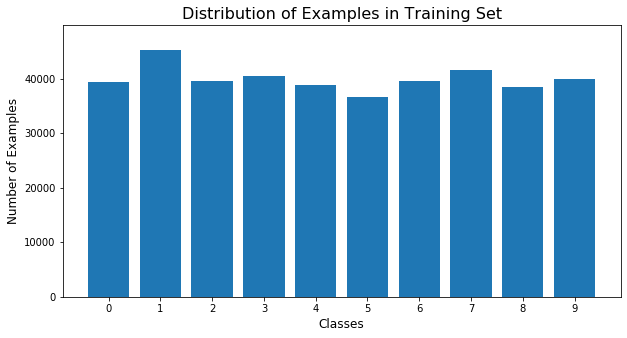

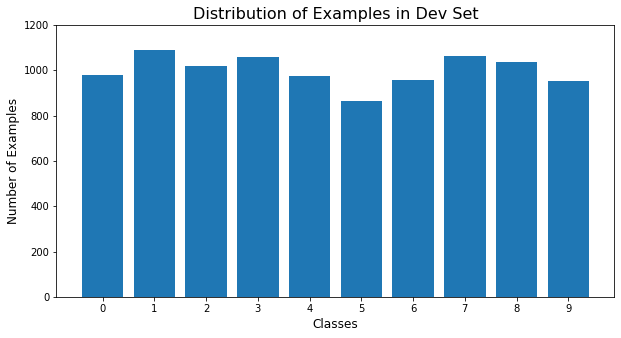

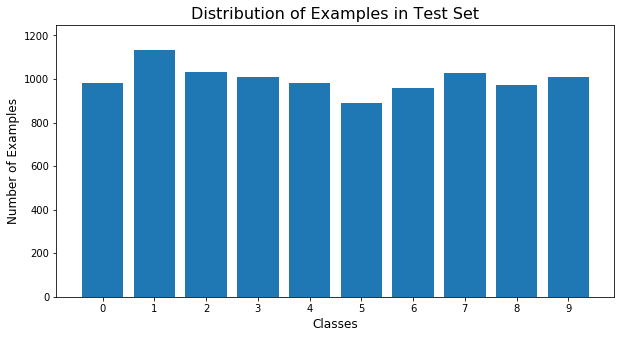

In [7]:
visualize_data_distribution(augmented_labels, dataset_type = "training")
visualize_data_distribution(dev_y_split,  dataset_type = "dev")
visualize_data_distribution(test_y_orig,  dataset_type = "test")

### Visualizing Dataset

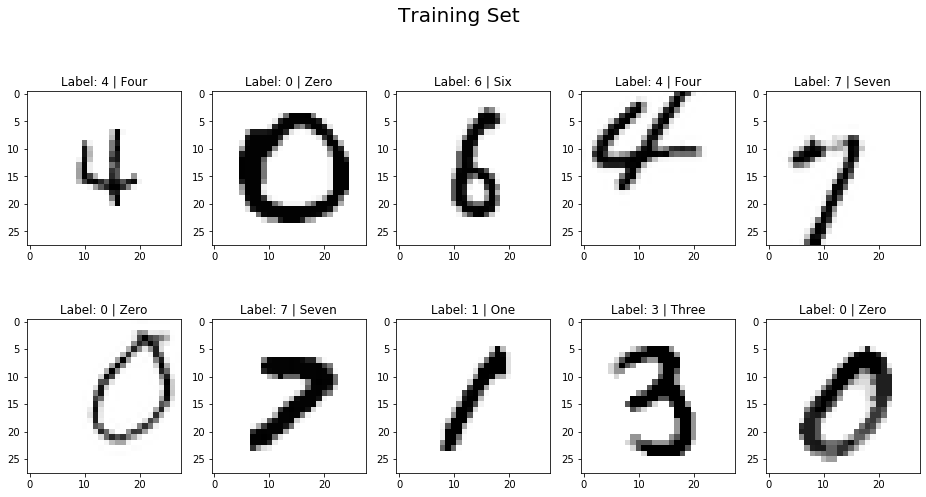

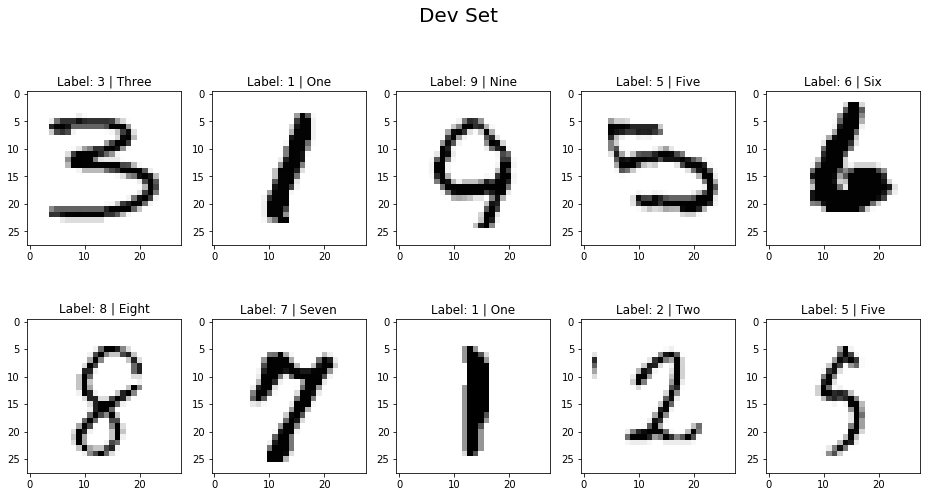

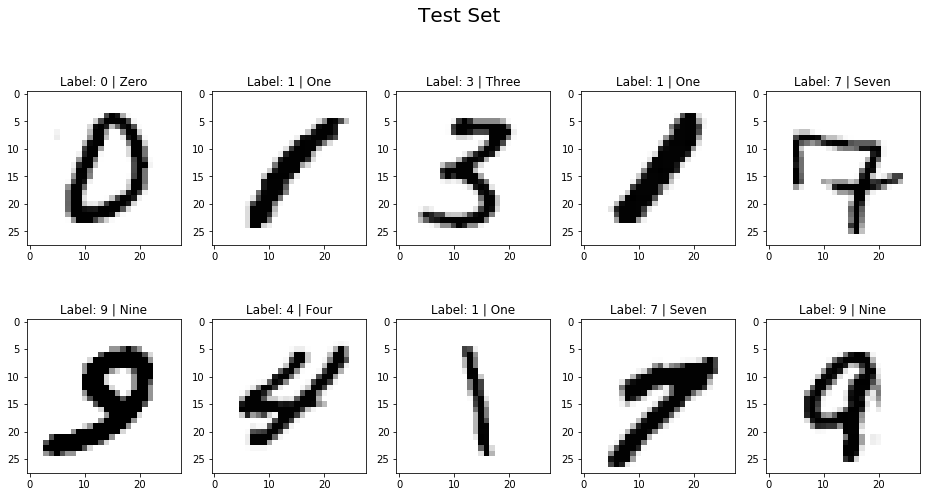

In [8]:
visualize_dataset(augmented_images, augmented_labels, dataset = "mnist", dataset_type = "training")
visualize_dataset(dev_x_split, dev_y_split, dataset = "mnist", dataset_type = "dev")
visualize_dataset(test_x_orig, test_y_orig, dataset = "mnist", dataset_type="test")

### Preparing Dataset

In [9]:
train_x_norm, train_y_encoded = prep_dataset(augmented_images, augmented_labels, num_class = 10)
dev_x_norm, dev_y_encoded= prep_dataset(dev_x_split, dev_y_split, num_class = 10)
test_x_norm, test_y_encoded = prep_dataset(test_x_orig, test_y_orig, num_class = 10)

print("Data\t\t\t","Before Processing\t","After Processing")
print("=================================================================")
print("Training Set Images:\t" + str(augmented_images.shape)+"\t\t"+ str(train_x_norm.shape))
print("Training Set Labels:\t" + str(augmented_labels.shape)+"\t\t"+ str(train_y_encoded.shape))
print("Dev Set Images:\t\t" + str(dev_x_split.shape)+"\t\t"+ str(dev_x_norm.shape))
print("Dev Set Labels:\t\t" + str(dev_y_split.shape)+"\t\t"+ str(dev_y_encoded.shape))
print("Test Set Images:\t" + str(test_x_orig.shape)+"\t\t"+ str(test_x_norm.shape))
print("Test Set Labels:\t" + str(test_y_orig.shape)+"\t\t"+ str(test_y_encoded.shape))
print("=================================================================")


Data			 Before Processing	 After Processing
Training Set Images:	(400000, 28, 28)		(784, 400000)
Training Set Labels:	(400000, 1)		(10, 400000)
Dev Set Images:		(10000, 28, 28)		(784, 10000)
Dev Set Labels:		(10000, 1)		(10, 10000)
Test Set Images:	(10000, 28, 28)		(784, 10000)
Test Set Labels:	(10000, 1)		(10, 10000)


In [10]:
train_x_orig = 0
train_x_split = 0

## Model Implementation

### Initializing the Model

#### Initializing Layers

In [11]:
def init_layers(X,Y,hidden_layers):
    """
        
        Arguments:
            
            
        Returns:
            
            
        Example:
            Here, shape of x = (784,m)
                  shape of y = (10,m)
            >>> layers_dim = init_layers(x, y, hidden_layers = [32,16])
            >>> print(layers_dim)
            
            Outputs:
                [784, 32, 16, 10]
    """
    input_nodes = X.shape[0]
    output_nodes = Y.shape[0]
    
    layers_dim = [input_nodes]
    
    for i in hidden_layers:
        layers_dim.append(i)
    
    layers_dim.append(output_nodes)
    
    return layers_dim

#### Initializing Parameters

In [12]:
def init_parameters(layers_dim, initialization = "random"):
    """
        
        Arguments:
            
            
        Returns:
            
            
        Example:
            Here, layers_dim = [784, 32, 16, 10]
            >>> parameters = init_parameters(layers_dim, initialization = "random")
            >>> print("Layer\tWeight\t\tBias")
            >>> print("================================")
            >>> for l in range(1,len(layers_dim)):
            ...     print(str(l) +"\t" + str(parameters['W'+str(l)].shape) +"\t"+ str(parameters['b'+str(l)].shape))

            
            Outputs:
                Layer    Weight         Bias
                ================================
                1        (32, 784)      (32, 1)
                2        (16, 32)       (16, 1)
                3        (10, 16)       (10, 1)
    """
    L = len(layers_dim)
    params = {}
        
    for l in range(1,L):
        #initializing Weights
        if initialization == "he":
            # he-initialization
            params['W' + str(l)] = np.random.randn(layers_dim[l],layers_dim[l-1]) * np.sqrt(np.divide(2,layers_dim[l-1])) 
        elif initialization == "random":
            # random initialization scaled by 0.01
            params['W' + str(l)] = np.random.randn(layers_dim[l],layers_dim[l-1]) * 0.01 
        else:
             raise ValueError("Initialization must be 'random' or 'he'")
        
        #initializing biases
        params['b' + str(l)] = np.zeros((layers_dim[l],1))
     
        assert(params['W' + str(l)].shape == (layers_dim[l],layers_dim[l-1])), "Dimention of W mismatched in init_params function"
        assert(params['b' + str(l)].shape == (layers_dim[l],1)), "Dimention of b mismatched in init_params function"
   
    return params

#### Initializing Hyper Parameters

In [13]:
def init_hyperParams(alpha, num_epoch, minibatch_size, lambd = 0, keep_probs = []):
    """
        
        Arguments:
            
            
        Returns:
            
            
        Example:
            >>> hyperParams = init_hyperParams(alpha = 0.0001, num_epoch = 10, minibatch_size = 1024,lambd = 0.7,keep_probs = [0.8,0.8])
    """
    hyperParams = {'learning_rate':alpha,
                   'num_epoch':num_epoch,
                   'mini_batch_size':minibatch_size,
                   'lambda':lambd,
                   'keep_probs':keep_probs,
                   'beta1':0.9,
                   'beta2':0.999,
                   'epsilon':1e-8
                  }
    
    return hyperParams

### Forward Propagation

#### Forward Sum for individual Layer

In [14]:
def forward_sum(A_prev,W,b):
    """
    
    
        Example:
            >>> np.random.seed(1)
            >>> A = np.random.randn(3,2)
            >>> W = np.random.randn(1,3)
            >>> b = np.random.randn(1,1)
            >>> Z, c = forward_sum(A,W,b)
            >>> print("Z = "+ str(Z))
            
            Output:
                Z = [[ 3.26295337 -1.23429987]]
        
    """
    m = A_prev.shape[1]
    
    Z = np.dot(W,A_prev) + b
    
    cache = (A_prev,W,b)
    
    assert (Z.shape == (W.shape[0], m)), "Dimention of Z mismatched in forward_prop function"
    
    return Z, cache

#### Forward Activation for individual Layer

In [15]:
def forward_activation(A_prev,W,b,activation):
    """
    
    
        Example:
            >>> np.random.seed(1)
            >>> A_prev = np.random.randn(3,2)
            >>> W = np.random.randn(1,3)
            >>> b = np.random.randn(1,1)

            >>> A,c = forward_activation(A_prev,W,b,activation = 'relu')
            >>> print("A with Relu = " + str(A))

            >>> A,c = forward_activation(A_prev,W,b,activation = 'softmax')
            >>> print("A with Softmax = " + str(A))
            
            Output:
                A with Relu = [[3.26295337 0.        ]]
                A with Softmax = [[1. 1.]]
    """
    
    if activation == 'relu':
        Z, sum_cache = forward_sum(A_prev,W,b)
        A, activation_cache = relu(Z)
        
    elif activation == 'softmax':
        Z, sum_cache = forward_sum(A_prev,W,b)
        A, activation_cache = softmax(Z)
    
    elif activation == "tanh":
#         Z, sum_cache = forward_sum(A_prev,W,b)
#         A, activation_cache = tanh(Z)
        pass
    
    cache = (sum_cache,activation_cache)
    
    assert(A.shape == Z.shape), "Dimention of A mismatched in forward_activation function"
    
    return A, cache

#### Dropout for individual Layer

In [16]:
def forward_dropout(A,keep_probs):
     #implementing dropout
    D = np.random.rand(A.shape[0],A.shape[1])
    D = (D < keep_probs).astype(int)
    A = np.multiply(A,D)
    A = np.divide(A,keep_probs)
    
    dropout_mask = D
    
    assert (dropout_mask.shape == A.shape), "Dimention of dropout_mask mismatched in forward_dropout function"
    
    return A,dropout_mask

#### Forward Prop for L Layers

In [17]:
def forward_prop(X, parameters, keep_probs = [], regularizer = None):
    """
    
        Example:
            >>> np.random.seed(1)
            >>> X = np.random.randn(3,2)
            >>> W1 = np.random.randn(3,3)
            >>> b1 = np.random.randn(3,1)
            >>> W2 = np.random.randn(2,3)
            >>> b2 = np.random.randn(2,1)
            >>> parameters = {"W1": W1,
                              "b1": b1,
                              "W2": W2,
                              "b2": b2}
            >>> AL, caches, _ = forward_prop(X, parameters)
            >>> print("AL without dropout = " + str(AL))

            >>> AL, caches, _ = forward_prop(X, parameters,keep_probs = [0.9], regularizer = "dropout")
            >>> print("\nAL with dropout = " + str(AL))

            >>> print("\nLength of caches list = " + str(len(caches)))
            
            Output:
                AL without dropout = [[0.25442549 0.64096177]
                 [0.74557451 0.35903823]]

                AL with dropout = [[0.20251119 0.61487938]
                 [0.79748881 0.38512062]]

                Length of caches list = 2
    
    """
    caches = []
    A = X
    L = len(parameters) // 2
    num_class = parameters["W"+str(L)].shape[0]
    
    dropout_masks = []

    # len(keep_probs) == L-1: no dropouts in the Output layer, no dropout at all for prediction
    if regularizer == "dropout":
        assert(len(keep_probs) == L-1 ) 
    
    for l in range(1, L):
        A_prev = A 
        A, cache = forward_activation(A_prev,parameters['W' + str(l)],parameters['b' + str(l)], activation='relu')
        caches.append(cache)
        if regularizer == "dropout":
            A , dropout_mask = forward_dropout(A,keep_probs[l-1])
            dropout_masks.append(dropout_mask)
        else:
            pass

    AL, cache = forward_activation(A, parameters['W' + str(L)], parameters['b' + str(L)], activation='softmax')
    caches.append(cache)
    
    assert(AL.shape == (num_class,X.shape[1])), "Dimention of AL mismatched in forward_prop function"
    
    return AL,caches,dropout_masks
    

### Compute Cost

In [18]:
def softmax_cross_entropy_cost(AL, Y, caches, lambd = 0, regularizer = None):
    """
    
    
        Example:
            >>> AL = np.array([[4.21200131e-01, 1.55876995e-04],
                           [6.91917292e-02, 1.18118501e-05],
                           [5.09608140e-01, 9.99832311e-01]])
            >>> cost = softmax_cross_entropy_cost(AL, Y, caches)
            >>> print("Cost without l2 = " + str(cost))

            >>> cost = softmax_cross_entropy_cost(AL, Y, caches, lambd = 0.7, regularizer = 'l2')
            >>> print("Cost with l2 = " + str(cost))
            
            Output:
                Cost without l2 = 0.6742809046007259
                Cost with l2 = 8.875542970361
    """
    
    L = len(caches)
    m = Y.shape[1]
    
    cost = -(1./m) * np.sum(np.sum(np.multiply(Y,np.log(AL + 1e-8)), axis = 0,keepdims=True))# add very small number 1e-8 to avoid log(0)

    if regularizer == "l2":
        norm = 0
        for l in range(L):
            current_cache = caches[l]
            sum_cache, _ = current_cache
            _,W,_ = sum_cache
            norm += np.sum(np.square(W))

        L2_cost = (lambd/(2*m)) * norm 
        cost = cost + L2_cost
    else:
        pass
    
    cost = np.squeeze(cost)      # Making sure your cost's shape is not returned as ndarray
    
    assert(cost.shape == ()),"Dimention of cost mismatched in softmax_cross_entropy_cost function"
    
    return cost

### Backward Propagation

#### Calculating Gradients for individual Layer

In [19]:
def backward_grad(dZ, cache, lambd, regularizer):
    """
    
        Example:
            >>> np.random.seed(1)
            >>> dZ = np.random.randn(3,4)
            >>> A = np.random.randn(5,4)
            >>> W = np.random.randn(3,5)
            >>> b = np.random.randn(3,1)
            >>> cache = (A, W, b)

            >>> dA_prev, dW, db = backward_grad(dZ, cache, lambd=0, regularizer=None)
            >>> print("Without L2 Regularization")
            >>> print ("dA_prev = "+ str(dA_prev))
            >>> print ("dW = " + str(dW))
            >>> print ("db = " + str(db))

            >>> l2_dA_prev, l2_dW, l2_db = backward_grad(dZ, cache, lambd = 0.9, regularizer = 'l2')
            >>> print("\nWith L2 Regularization")
            >>> print ("dA_prev = "+ str(l2_dA_prev))
            >>> print ("dW = " + str(l2_dW))
            >>> print ("db = " + str(l2_db))
            
            Output:
                Without L2 Regularization
                dA_prev = [[-1.15171336  0.06718465 -0.3204696   2.09812712]
                           [ 0.60345879 -3.72508701  5.81700741 -3.84326836]
                           [-0.4319552  -1.30987417  1.72354705  0.05070578]
                           [-0.38981415  0.60811244 -1.25938424  1.47191593]
                           [-2.52214926  2.67882552 -0.67947465  1.48119548]]
                dW = [[ 0.07313866 -0.0976715  -0.87585828  0.73763362  0.00785716]
                      [ 0.85508818  0.37530413 -0.59912655  0.71278189 -0.58931808]
                      [ 0.97913304 -0.24376494 -0.08839671  0.55151192 -0.10290907]]
                db = [[-0.14713786]
                      [-0.11313155]
                      [-0.13209101]]

                With L2 Regularization
                dA_prev = [[-1.15171336  0.06718465 -0.3204696   2.09812712]
                           [ 0.60345879 -3.72508701  5.81700741 -3.84326836]
                           [-0.4319552  -1.30987417  1.72354705  0.05070578]
                           [-0.38981415  0.60811244 -1.25938424  1.47191593]
                           [-2.52214926  2.67882552 -0.67947465  1.48119548]]
                dW = [[-0.0814752  -0.28784277 -1.02688866  0.73478408 -0.24353767]
                      [ 0.90783172  0.74875962 -0.43216662  0.6696189  -0.78903459]
                      [ 0.81102242  0.13703735 -0.07696496  0.4081879  -0.05995309]]
                db = [[-0.14713786]
                      [-0.11313155]
                      [-0.13209101]]
    """
    
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    if regularizer == "l2":
        dW = (1/m) * np.dot(dZ,A_prev.T) + np.multiply(np.divide(lambd,m),W )
    else:
        dW = (1/m) * np.dot(dZ,A_prev.T)

    db = (1/m) * np.sum(dZ, axis = 1, keepdims=True )
    dA_prev = np.dot(W.T, dZ)

    
    assert (dW.shape == W.shape), "Dimention of dW mismatched in backward_grad function"
    assert (db.shape == b.shape), "Dimention of db mismatched in backward_grad function"
    assert (dA_prev.shape == A_prev.shape), "Dimention of dA_prev mismatched in backward_grad function"
    
    
    return dA_prev, dW, db

#### Calculating Backward Activation for individual layer

In [20]:
def backward_activation(dA, cache, lambd ,regularizer, activation):
    """
    
    
    Example:
        >>> np.random.seed(2)
        >>> dA = np.random.randn(1,2)
        >>> A = np.random.randn(3,2)
        >>> W = np.random.randn(1,3)
        >>> b = np.random.randn(1,1)
        >>> Z = np.random.randn(1,2)
        >>> sum_cache = (A, W, b)
        >>> activation_cache = Z
        >>> cache = (sum_cache, activation_cache)

        >>> dA_prev, dW, db = backward_activation(dA, cache, lambd = 0 ,regularizer = None, activation = "relu")
        >>> print("With Relu")
        >>> print ("dA_prev = "+ str(dA_prev))
        >>> print ("dW = " + str(dW))
        >>> print ("db = " + str(db))

        >>> dA_prev, dW, db = backward_activation(dA, cache, lambd = 0 ,regularizer = None, activation = "softmax")
        >>> print("\nWith Softmax")
        >>> print ("dA_prev = "+ str(dA_prev))
        >>> print ("dW = " + str(dW))
        >>> print ("db = " + str(db))
        
        Output: 
            With Relu
            dA_prev = [[ 0.44090989 -0.        ]
                       [ 0.37883606 -0.        ]
                       [-0.2298228   0.        ]]
            dW = [[ 0.44513824  0.37371418 -0.10478989]]
            db = [[-0.20837892]]

            With Softmax
            dA_prev = [[ 0.44090989  0.05952761]
                       [ 0.37883606  0.05114697]
                       [-0.2298228  -0.03102857]]
            dW = [[ 0.39899183  0.3973954  -0.06975568]]
            db = [[-0.23651234]]
    """
    
    
    
    sum_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_grad(dA,activation_cache)
        dA_prev, dW, db = backward_grad(dZ, sum_cache, lambd, regularizer = regularizer)
        
    elif activation == "softmax":
        dZ = dA
        dA_prev, dW, db = backward_grad(dZ, sum_cache, lambd, regularizer = regularizer)
    
    elif activation == "tanh":
        pass
#         dZ = tanh_grad(dA,activation_cache)
#         dA_prev, dW, db = backward_grad(dZ, sum_cache, lambd, regularizer = regularizer)
    
    return dA_prev, dW, db
    
    

#### Complete Backward Propagation for L layers

In [21]:
def backward_dropout(dA_prev_temp, D, keep_prob):
    dA_prev = np.multiply(dA_prev_temp,D)
    dA_prev = np.divide(dA_prev,keep_prob)
    
    return dA_prev

In [22]:
def backward_prop(AL, Y, caches, dropout_masks = [], keep_probs = [], lambd = 0, regularizer = None):
    """
    
        Example:
            >>> np.random.seed(3)
            >>> AL = np.random.randn(1, 2)
            >>> Y = np.array([[1, 0]])

            >>> A1 = np.random.randn(4,2)
            >>> W1 = np.random.randn(3,4)
            >>> b1 = np.random.randn(3,1)
            >>> Z1 = np.random.randn(3,2)
            >>> cache_activation_1 = ((A1, W1, b1), Z1)

            >>> A2 = np.random.randn(3,2)
            >>> W2 = np.random.randn(1,3)
            >>> b2 = np.random.randn(1,1)
            >>> Z2 = np.random.randn(1,2)
            >>> cache_activation_2 = ((A2, W2, b2), Z2)

            >>> caches = (cache_activation_1, cache_activation_2)

            >>> grads = backward_prop(AL, Y, caches)
            >>> for key,value in grads.items():
            ...     print(str(key)+" : "+str(value))
            
            Output:
                dA1 : [[-0.80745758 -0.44693186]
                       [ 0.88640102  0.49062745]
                       [-0.10403132 -0.05758186]]
                dW2 : [[ 0.50767257 -0.42243102 -1.15550109]]
                db2 : [[0.61256916]]
                dA0 : [[ 0.          0.53064147]
                       [ 0.         -0.3319644 ]
                       [ 0.         -0.32565192]
                       [ 0.         -0.75222096]]
                dW1 : [[0.41642713 0.07927654 0.14011329 0.10664197]
                       [0.         0.         0.         0.        ]
                       [0.05365169 0.01021384 0.01805193 0.01373955]]
                db1 : [[-0.22346593]
                       [ 0.        ]
                       [-0.02879093]]
    """
    
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    dA = np.subtract(AL,Y)
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = backward_activation(dA, current_cache,lambd = lambd, regularizer = regularizer, activation = 'softmax')
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        
        if regularizer == "dropout":
            #implementing dropout
            D = dropout_masks[l]
            dA_prev_temp = backward_dropout(grads["dA" + str(l + 1)], D, keep_probs[l])
            dA_prev, dW_temp, db_temp = backward_activation(dA_prev_temp, current_cache, lambd = lambd, regularizer = regularizer, activation = 'relu')
        else:
            dA_prev, dW_temp, db_temp = backward_activation(grads["dA" + str(l + 1)], current_cache, lambd = lambd, regularizer = regularizer, activation = 'relu')
            
        
        grads["dA" + str(l)] = dA_prev
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

### Update Parameters

In [23]:
#initialize adam

def initialize_adam(parameters) :
   
    L = len(parameters) // 2 
    v = {}
    s = {}
    
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
    
    return v, s

In [24]:
def update_parameters(parameters, grads, learning_rate, optimizer = "bgd", beta1 = 0, beta2 = 0,  epsilon = 0, v = {}, s = {}, t = 0):
    """
    
    
        Example:
            >>> np.random.seed(2)
            >>> W1 = np.random.randn(3,4)
            >>> b1 = np.random.randn(3,1)
            >>> W2 = np.random.randn(1,3)
            >>> b2 = np.random.randn(1,1)
            >>> parameters = {"W1": W1,
                          "b1": b1,
                          "W2": W2,
                          "b2": b2}
            >>> np.random.seed(3)
            >>> dW1 = np.random.randn(3,4)
            >>> db1 = np.random.randn(3,1)
            >>> dW2 = np.random.randn(1,3)
            >>> db2 = np.random.randn(1,1)
            >>> grads = {"dW1": dW1,
                     "db1": db1,
                     "dW2": dW2,
                     "db2": db2}

            >>> parameters,_,_ = update_parameters(parameters, grads, 0.1)

            >>> print ("W1 = "+ str(parameters["W1"]))
            >>> print ("b1 = "+ str(parameters["b1"]))
            >>> print ("W2 = "+ str(parameters["W2"]))
            >>> print ("b2 = "+ str(parameters["b2"]))
            
            Output:
                W1 = [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
                      [-1.76569676 -0.80627147  0.51115557 -1.18258802]
                      [-1.0535704  -0.86128581  0.68284052  2.20374577]]
                b1 = [[-0.04659241]
                      [-1.28888275]
                      [ 0.53405496]]
                W2 = [[-0.55569196  0.0354055   1.32964895]]
                b2 = [[-0.84610769]]
    """
    L = len(parameters) // 2           
    v_corrected = {}                         
    s_corrected = {}                       
    
    for l in range(L):
        if optimizer == 'adam':
            # Moving average of the gradients.
            v["dW" + str(l+1)] = np.add(beta1 * v["dW" + str(l+1)], (1 - beta1) * grads["dW" + str(l+1)])
            v["db" + str(l+1)] = np.add(beta1 * v["db" + str(l+1)], (1 - beta1) * grads["db" + str(l+1)])

            # Compute bias-corrected first moment estimate.
            v_corrected["dW" + str(l+1)] = np.divide(v["dW" + str(l+1)], (1 - np.power(beta1,t)))
            v_corrected["db" + str(l+1)] = np.divide(v["db" + str(l+1)], (1 - np.power(beta1,t)))

            # Moving average of the squared gradients. 
            s["dW" + str(l+1)] = np.add(beta2 * s["dW" + str(l+1)], (1 - beta2) * np.square(grads["dW" + str(l+1)]))
            s["db" + str(l+1)] = np.add(beta2 * s["db" + str(l+1)], (1 - beta2) * np.square(grads["db" + str(l+1)]))

            # Compute bias-corrected second raw moment estimate. 
            s_corrected["dW" + str(l+1)] = np.divide(s["dW" + str(l+1)], (1 - np.power(beta2,t)))
            s_corrected["db" + str(l+1)] = np.divide(s["db" + str(l+1)], (1 - np.power(beta2,t)))

            # Update parameters. 
            parameters["W" + str(l+1)] = np.subtract(parameters["W" + str(l+1)],  learning_rate * np.divide(v_corrected["dW" + str(l+1)], np.sqrt(s_corrected["dW" + str(l+1)]) + epsilon))
            parameters["b" + str(l+1)] = np.subtract(parameters["b" + str(l+1)],  learning_rate * np.divide(v_corrected["db" + str(l+1)], np.sqrt(s_corrected["db" + str(l+1)]) + epsilon))
        else:
            parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - (learning_rate * grads["dW" + str(l+1)])
            parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - (learning_rate * grads["db" + str(l+1)])
            
    return parameters, v, s

### Evaluate Model

In [25]:
# Evaluating the model using acc and loss
def evaluate(X, Y, parameters):
    """
    
        Example:
            >>> np.random.seed(1)
            >>> X = np.random.randn(3,2)
            >>> Y = np.array([[1, 0, 0],[0,1,1]]).reshape(3,2)
            >>> W1 = np.random.randn(5,3)
            >>> b1 = np.random.randn(5,1)
            >>> W2 = np.random.randn(3,5)
            >>> b2 = np.random.randn(3,1)
            >>> parameters = {"W1": W1,
            ...               "b1": b1,
            ...               "W2": W2,
            ...               "b2": b2}
            >>> acc, loss = evaluate(X, Y, parameters)
            >>> print("acc = %f | cost = %f"%(acc,loss))
            
            Output:
                acc = 0.500000 | cost = 0.769464
    """
    
    m = Y.shape[1]
    
    # predicting output using fordward propogation 
    probas, caches, _ = forward_prop(X, parameters)
    #computing loss
    loss = softmax_cross_entropy_cost(probas, Y, caches) 
    
    #deriving the predictrueted labels
    true_labels = np.argmax(Y,axis=0).reshape(1,m)
    #deriving the predicted labels
    predicted_labels = np.argmax(probas,axis=0).reshape(1,m)
    
    #identifing correctly predicted labels
    correct_prediction = np.equal(predicted_labels,true_labels)
    
    #computing accuracy
    num_correct_prediction = np.sum(correct_prediction)
    accuracy = (num_correct_prediction/m)
    
    return accuracy, loss

### Train Model

In [26]:
# Final Model Training

def train(X_train, Y_train, X_dev, Y_dev, layers_dim, hyperParams, initialization = "random", optimizer = 'bgd',regularizer = None, verbose = 3, patience = 0):
    # loading the hyper parameters
    learning_rate = hyperParams['learning_rate']
    num_epoch = hyperParams['num_epoch']
    b1 = hyperParams['beta1']
    b2 = hyperParams['beta2']
    ep = hyperParams['epsilon']
    lambd = hyperParams['lambda']
    keep_probs = hyperParams['keep_probs']

#     #validating Early Stopping
#     assert(patience == 0 or patience >=5), "Evaluate the accuracy of at least 5 epoch before early stopping"
    
    #initializing the variables
    seed = 1
    m = Y_train.shape[1]
    train_accs = []  # keep track of training accuracy
    val_accs = []     # keep track of Validation accuracy
    train_losses = []  # keep track of training loss
    val_losses = []     # keep track of Validation loss
    
#     early_stop_count = 0 #for early stopping
#     max_val_acc = 0 # for keeping track of maximum validation accuracy
#     all_params = [] # for keeping track of parameters corresponding to the max validation accuracy

    #selecting the minibatch size for each optimizer
    if optimizer == 'sgd':
        mini_batch_size = 1
    elif optimizer == 'bgd':
        mini_batch_size = m
    elif optimizer == 'mgd' or optimizer == 'adam':
        mini_batch_size = hyperParams['mini_batch_size']
    else:
        raise ValueError("Optimizer value out of scope")
        
    #initializing the model parameters
    parameters = init_parameters(layers_dim, initialization)
    
    #initializing adam parameters, used only when optimizer = 'adam'
    t = 0
    v,s = initialize_adam(parameters)
    
    train_toc = time.time() # for calculating entire training time
    print("Training The Model...")
    
    #Gradient Descent begins
    for i in range(1, num_epoch+1):
        seed += 1
        time_trained = 0
        batch_times = []
        accs = []
        losses = []
        
        if verbose > 0:
            print("\nEpoch %d/%d"%(i,num_epoch))
        
        minibatches = rand_mini_batches(X_train, Y_train, mini_batch_size, seed)
        total_minibatches = len(minibatches)
        
        for ind, minibatch in enumerate(minibatches):
            batch_toc = time.time() # for calculating time of an epoch cycle
            
            #retriving minibatch of X and Y from training set
            (minibatch_X, minibatch_Y) = minibatch
            
            #forward Propagation
            AL, caches, dropout_masks = forward_prop(minibatch_X, parameters, keep_probs = keep_probs, regularizer = regularizer)
            
            #Computing cross entropy cost
            cross_entropy_cost = softmax_cross_entropy_cost(AL, minibatch_Y, caches, lambd = lambd, regularizer = regularizer) #accumulating the batch costs
            
            #Backward Propagation
            grads = backward_prop(AL, minibatch_Y, caches, dropout_masks = dropout_masks, keep_probs = keep_probs, lambd = lambd, regularizer = regularizer)
                
            #Updating parameters
            t += 1
            parameters, v, s = update_parameters(parameters, grads, learning_rate, optimizer = optimizer, beta1 = b1, beta2 = b2,  epsilon = ep, v = v, s = s, t = t)
            
            # Calculating training time for each batch 
            batch_tic = time.time()
            batch_times.append(batch_tic - batch_toc)
            time_trained = np.sum(batch_times)
            
            #calculating training progress
            per = ((ind+1) / total_minibatches) * 100
            inc = int(per // 10) * 2
            
            #calculating accuracy and loss of the training batch
            acc,loss = evaluate(minibatch_X, minibatch_Y, parameters)
            accs.append(acc)
            losses.append(loss)
            
            #averaging all the accs and losses till now
            train_acc = np.mean(accs)
            train_loss = np.mean(losses)
            
            #Verbosity 0: Silent mode
            #Verbosity 1: Epoch mode
            #Verbosity 2: Progress bar mode
            #Verbosity 3 or greater: Metric mode
                
            if verbose == 2:
                print ("%d/%d [%s>%s %.0f%%] - %.2fs"%(ind+1, total_minibatches, '=' * inc,'.'*(20-inc), per, time_trained),end='\r')
            elif verbose > 2:
                print ("%d/%d [%s>%s %.0f%%] - %.2fs | loss: %.4f | acc: %.4f"%(ind+1, total_minibatches, '=' * inc,'.'*(20-inc), per, time_trained, train_loss, train_acc),end='\r')
            
        #----------------------------------------------batch ends-------------------------------------------
        
        #accumulating the acc and loss of the last iteration of each epoch
        train_accs.append(np.mean(accs))
        train_losses.append(np.mean(losses))
                
        #evaluating the model using validation accuracy and loss
        val_acc, val_loss= evaluate(X_dev, Y_dev, parameters)  
        val_accs.append(val_acc)
        val_losses.append(val_loss)
        
        #calculating Epoch Cost
#         costs.append(np.mean(batch_cost))

        time_per_batch = int(np.mean(batch_times)*1000)

        if verbose == 2:
            print ("%d/%d [%s 100%%] - %.2fs %dms/step"%(total_minibatches, total_minibatches, '=' * 20, time_trained, time_per_batch ),end='\r')
        elif verbose > 2:
            print ("%d/%d [%s 100%%] - %.2fs %dms/step | loss: %.4f | acc: %.4f | val_loss: %.4f | val_acc: %.4f"%(total_minibatches, total_minibatches, '=' * 20, time_trained, time_per_batch, train_loss, train_acc, val_loss, val_acc),end='\r')
                
        
        
#         #getting the best val accuracy
#         if val_acc >= max_val_acc:
#             max_val_acc = val_acc
            
#         # Early Stopping
#         if patience >= 5:
#             epoch_trained = i+1
            
#             if val_acc < max_val_acc:
#                 early_stop_count += 1
#             else:
#                 early_stop_count = 0

#             if early_stop_count == patience:
#                 print("\n\nSince the Val Acc didn't increase for last %d epochs, Training is halted returning the best parameters obtained."%patience)
#                 break;
          
#         all_params.append(parameters)
    #-------------------------------------------Gradient Descent ends-----------------------------------------------
    
    train_tic = time.time() # for calculating entire training time
    hrs, mins, secs , ms = convert_time((train_tic - train_toc)*1000)
    print("\n\nTotal Training Time = %dhr %dmins %dsecs %.2fms"%(hrs, mins, secs, ms))
    
#     best_params = all_params[np.argmax(val_acc)]
     
    history = {"parameters":parameters,
               "accuracy": train_accs,
               "loss":train_losses ,
               "val_accuracy":val_accs,
               "val_loss":val_losses
            }
    return history


#### Running Model

In [28]:
layers_dim = init_layers(train_x_norm, train_y_encoded, hidden_layers = [1024,512])
hyperParams = init_hyperParams(alpha = 0.001, num_epoch = 30, minibatch_size = 64,lambd = 0.7,keep_probs = [0.8,0.8])
history = train(train_x_norm, train_y_encoded, dev_x_norm, dev_y_encoded,layers_dim, hyperParams, initialization = "he", optimizer = 'adam',regularizer = "dropout", verbose = 3, patience = 5)

Training The Model...

Epoch 1/30
6250/6250 [==================== 100%] - 190.29s 30ms/step | loss: 0.1826 | acc: 0.9452 | val_loss: 0.0618 | val_acc: 0.9805
Epoch 2/30
6250/6250 [==================== 100%] - 194.54s 31ms/step | loss: 0.0793 | acc: 0.9758 | val_loss: 0.0541 | val_acc: 0.9856
Epoch 3/30
6250/6250 [==================== 100%] - 192.18s 30ms/step | loss: 0.0580 | acc: 0.9820 | val_loss: 0.0467 | val_acc: 0.9861
Epoch 4/30
6250/6250 [==================== 100%] - 192.81s 30ms/step | loss: 0.0469 | acc: 0.9853 | val_loss: 0.0571 | val_acc: 0.9829
Epoch 5/30
6250/6250 [==================== 100%] - 193.28s 30ms/step | loss: 0.0393 | acc: 0.9875 | val_loss: 0.0482 | val_acc: 0.9857
Epoch 6/30
6250/6250 [==================== 100%] - 194.68s 31ms/step | loss: 0.0338 | acc: 0.9891 | val_loss: 0.0545 | val_acc: 0.9857
Epoch 7/30
6250/6250 [==================== 100%] - 253.43s 40ms/step | loss: 0.0301 | acc: 0.9906 | val_loss: 0.0537 | val_acc: 0.9875
Epoch 8/30
6250/6250 [==========

In [ ]:
a = {'a':2,
     'b':3
}
b = {'a':2,
     'b':3,
#      'c':4
}
assert(a==b)

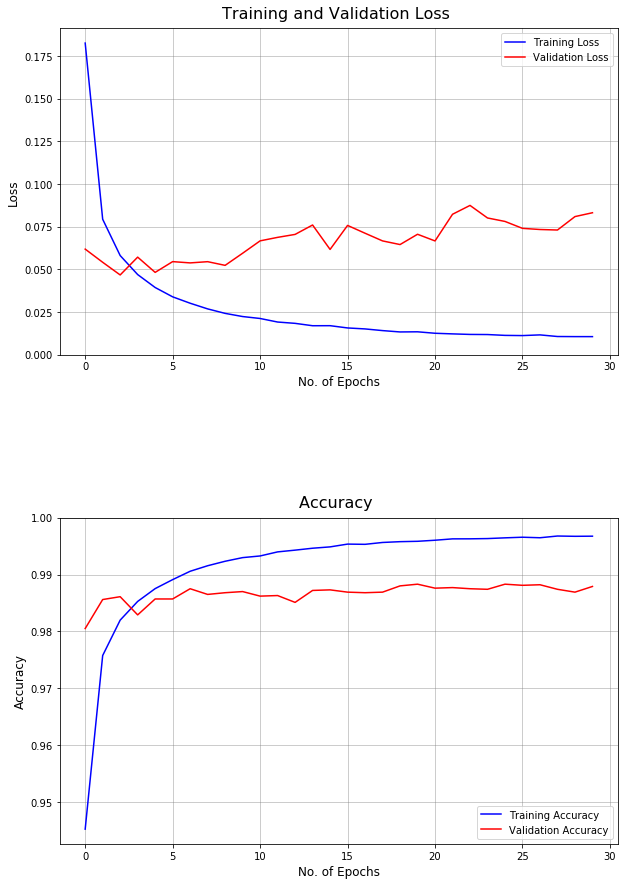

In [29]:
params = history["parameters"]
train_acc = history["accuracy"]
train_loss = history["loss"]
val_acc = history["val_accuracy"]
val_loss = history["val_loss"]
epochs = len(val_acc)


visualize_training_results(train_acc, val_acc, train_loss, val_loss)    

In [30]:
print("\n Epochs\t | Train Acc\t | Train Loss\t | Val Acc\t | Val Loss")
print("--------------------------------------------------------------------")
for i in range(epochs):
    print(" %d\t | %f\t | %f\t | %f\t | %f"%(i+1,train_acc[i] ,train_loss[i],val_acc[i] ,val_loss[i] ))


 Epochs	 | Train Acc	 | Train Loss	 | Val Acc	 | Val Loss
--------------------------------------------------------------------
 1	 | 0.945227	 | 0.182558	 | 0.980500	 | 0.061802
 2	 | 0.975758	 | 0.079308	 | 0.985600	 | 0.054086
 3	 | 0.981980	 | 0.058023	 | 0.986100	 | 0.046658
 4	 | 0.985267	 | 0.046887	 | 0.982900	 | 0.057104
 5	 | 0.987520	 | 0.039300	 | 0.985700	 | 0.048171
 6	 | 0.989102	 | 0.033831	 | 0.985700	 | 0.054469
 7	 | 0.990570	 | 0.030087	 | 0.987500	 | 0.053720
 8	 | 0.991542	 | 0.026767	 | 0.986500	 | 0.054438
 9	 | 0.992330	 | 0.024137	 | 0.986800	 | 0.052282
 10	 | 0.992970	 | 0.022284	 | 0.987000	 | 0.059376
 11	 | 0.993263	 | 0.021141	 | 0.986200	 | 0.066642
 12	 | 0.993977	 | 0.019065	 | 0.986300	 | 0.068687
 13	 | 0.994285	 | 0.018292	 | 0.985100	 | 0.070420
 14	 | 0.994622	 | 0.016897	 | 0.987200	 | 0.075934
 15	 | 0.994857	 | 0.016925	 | 0.987300	 | 0.061618
 16	 | 0.995348	 | 0.015598	 | 0.986900	 | 0.075685
 17	 | 0.995308	 | 0.015025	 | 0.986800	 | 0.0711

### Prediction

In [31]:
# Making Predictions
def predict(X, parameters, second_guess = False):
    prediction = {}
    
    # Computing the Output predictions. 
    # no keep_probs : no dropout during prediction 
    probas, caches, _ = forward_prop(X, parameters)
    
    #getting the number of examples
    m = probas.shape[1]

    #deriving the predicted labels with their probabilities
    predicted_labels = np.argmax(probas,axis=0).reshape(1,m)
    predicted_prob = np.max(probas,axis = 0).reshape(1,m)
    
    #Computing the second guess
    if second_guess == True:
        second_max = np.array(probas, copy=True)
        second_max[predicted_labels,np.arange(m)] = 0 #zeroing out the first max prediction
        sec_predicted_labels = np.argmax(second_max,axis=0).reshape(1,m) #selecting the second max predicted label
        sec_predicted_prob = np.max(second_max,axis = 0).reshape(1,m) #selecting the second max prediction

        prediction["Second Prediction"] = [sec_predicted_labels, sec_predicted_prob]      

    prediction["First Prediction"] = [predicted_labels, predicted_prob]
    

    return prediction

In [32]:
prediction_train = predict(train_x_norm, params, second_guess = True)
prediction_dev = predict(dev_x_norm,params, second_guess = True)
prediction_test = predict(test_x_norm, params, second_guess = True)

### Confusion Matrix

In [33]:
cm_train = confusion_matrix(augmented_labels, prediction_train)
cm_dev = confusion_matrix(dev_y_split, prediction_dev)
cm_test = confusion_matrix(test_y_orig, prediction_test)

# print("\nConfusion Matrix for Training set:\n")
# print(cm_train)

# print("\nConfusion Matrix for Dev set:\n")
# print(cm_dev)

# print("\nConfusion Matrix for Test set:\n")
# print(cm_test)

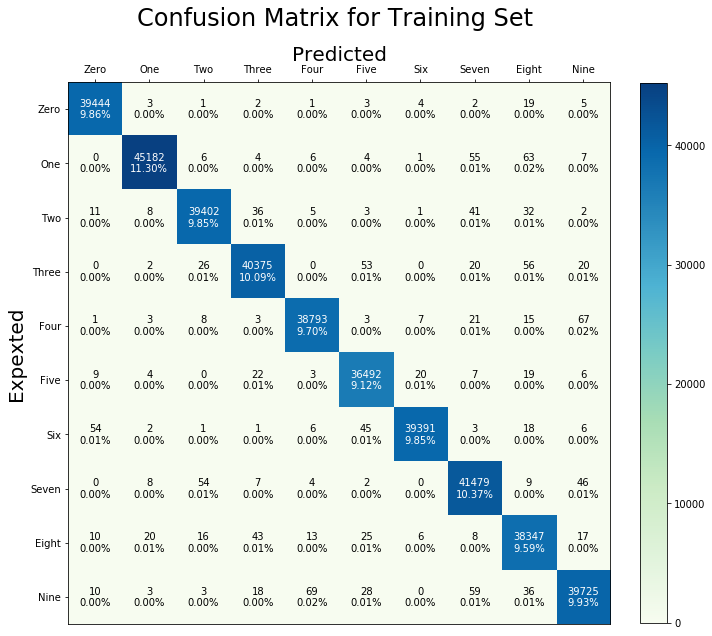

In [34]:
#plotting the confusion matrix   
plot_confusion_matrix(cm_train, dataset_type = "training")

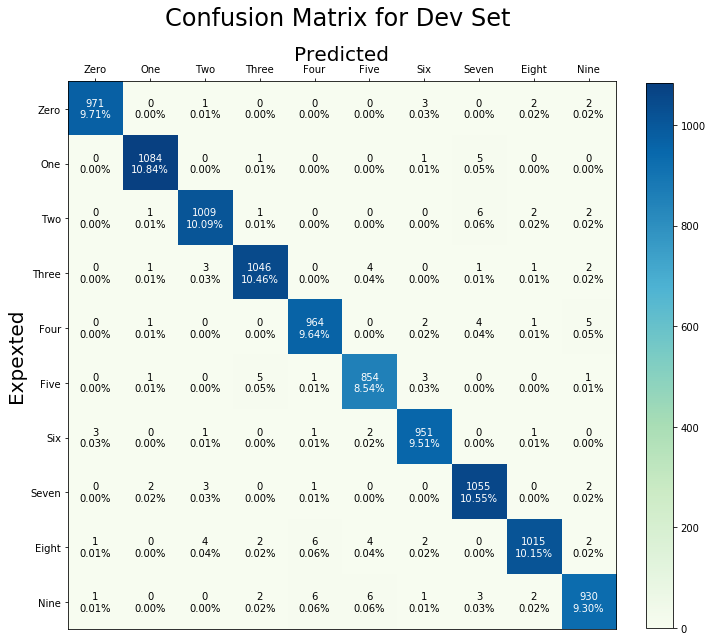

In [35]:
plot_confusion_matrix(cm_dev, dataset_type = "dev")

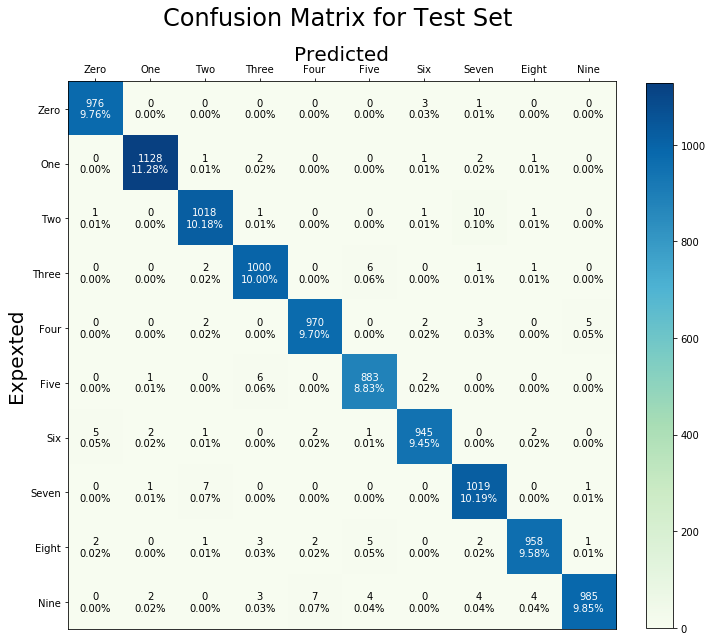

In [36]:
plot_confusion_matrix(cm_test, dataset_type = "test")

In [37]:
metrics, macro_metrics, acc = model_metrics(cm_train)
metric_summary(metrics, macro_metrics, acc)

+===============+===============+===============+===============+
| Label 	| Precision 	| Recall 	| F1 Score 	|
+===============+===============+===============+===============+
| 0 		|  0.99760 	|  0.99899 	|  0.99829 	|
| 1 		|  0.99883 	|  0.99678 	|  0.99780 	|
| 2 		|  0.99709 	|  0.99648 	|  0.99679 	|
| 3 		|  0.99664 	|  0.99564 	|  0.99614 	|
| 4 		|  0.99725 	|  0.99671 	|  0.99698 	|
| 5 		|  0.99547 	|  0.99754 	|  0.99650 	|
| 6 		|  0.99901 	|  0.99656 	|  0.99778 	|
| 7 		|  0.99482 	|  0.99688 	|  0.99585 	|
| 8 		|  0.99309 	|  0.99590 	|  0.99449 	|
| 9 		|  0.99559 	|  0.99434 	|  0.99497 	|
+===============+===============+===============+===============+
| Macro Avg 	|  0.99654 	|  0.99658 	|  0.99656 	|
+===============+===============+===============+===============+

 Accuracy 		  0.99657


In [38]:
metrics, macro_metrics, acc = model_metrics(cm_dev)
metric_summary(metrics, macro_metrics, acc)

+===============+===============+===============+===============+
| Label 	| Precision 	| Recall 	| F1 Score 	|
+===============+===============+===============+===============+
| 0 		|  0.99488 	|  0.99183 	|  0.99335 	|
| 1 		|  0.99450 	|  0.99358 	|  0.99404 	|
| 2 		|  0.98825 	|  0.98825 	|  0.98825 	|
| 3 		|  0.98959 	|  0.98866 	|  0.98913 	|
| 4 		|  0.98468 	|  0.98669 	|  0.98569 	|
| 5 		|  0.98161 	|  0.98728 	|  0.98444 	|
| 6 		|  0.98754 	|  0.99166 	|  0.98959 	|
| 7 		|  0.98231 	|  0.99247 	|  0.98737 	|
| 8 		|  0.99121 	|  0.97973 	|  0.98544 	|
| 9 		|  0.98309 	|  0.97792 	|  0.98050 	|
+===============+===============+===============+===============+
| Macro Avg 	|  0.98776 	|  0.98781 	|  0.98778 	|
+===============+===============+===============+===============+

 Accuracy 		  0.98790


In [39]:
metrics, macro_metrics, acc = model_metrics(cm_test)
metric_summary(metrics, macro_metrics, acc)

+===============+===============+===============+===============+
| Label 	| Precision 	| Recall 	| F1 Score 	|
+===============+===============+===============+===============+
| 0 		|  0.99187 	|  0.99592 	|  0.99389 	|
| 1 		|  0.99471 	|  0.99383 	|  0.99427 	|
| 2 		|  0.98643 	|  0.98643 	|  0.98643 	|
| 3 		|  0.98522 	|  0.99010 	|  0.98765 	|
| 4 		|  0.98879 	|  0.98778 	|  0.98828 	|
| 5 		|  0.98220 	|  0.98991 	|  0.98604 	|
| 6 		|  0.99057 	|  0.98643 	|  0.98849 	|
| 7 		|  0.97793 	|  0.99125 	|  0.98454 	|
| 8 		|  0.99069 	|  0.98357 	|  0.98712 	|
| 9 		|  0.99294 	|  0.97621 	|  0.98451 	|
+===============+===============+===============+===============+
| Macro Avg 	|  0.98814 	|  0.98814 	|  0.98812 	|
+===============+===============+===============+===============+

 Accuracy 		  0.98820


#### Visualizating  Prediction

In [ ]:
visualize_prediction(augmented_images, augmented_labels.T, prediction_train, dataset_type = "training")

In [ ]:
visualize_prediction(dev_x_split, dev_y_split.T, prediction_dev, dataset_type = "dev")

In [ ]:
visualize_prediction(test_x_orig, test_y_orig.T, prediction_test,dataset_type = "test")

#### Visualizing Mislabelled Images in all datasets

In [ ]:
visualize_mislabelled_images(augmented_images, augmented_labels.T,prediction_train,dataset_type = "training")

Total Mislabelled Images: 121


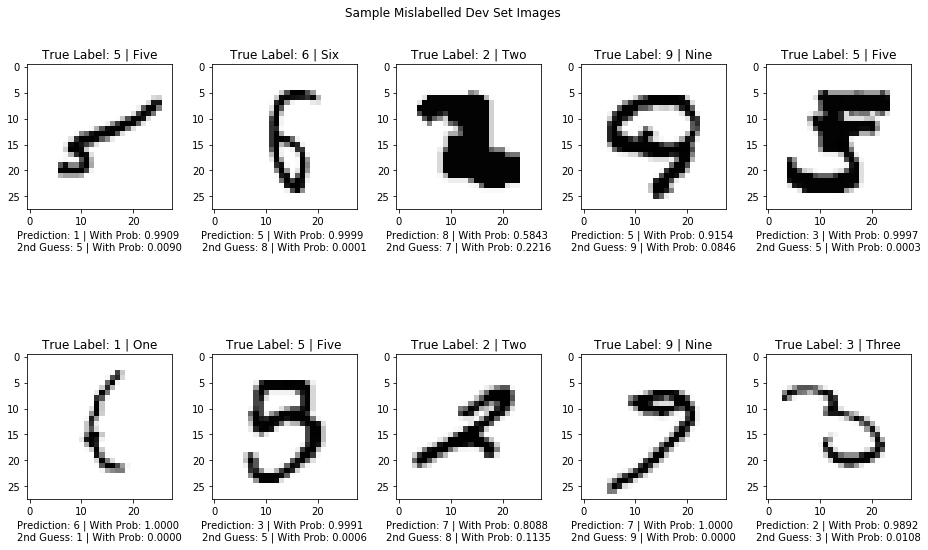

In [40]:
visualize_mislabelled_images(dev_x_split, dev_y_split.T, prediction_dev,dataset_type = "dev")

Total Mislabelled Images: 118


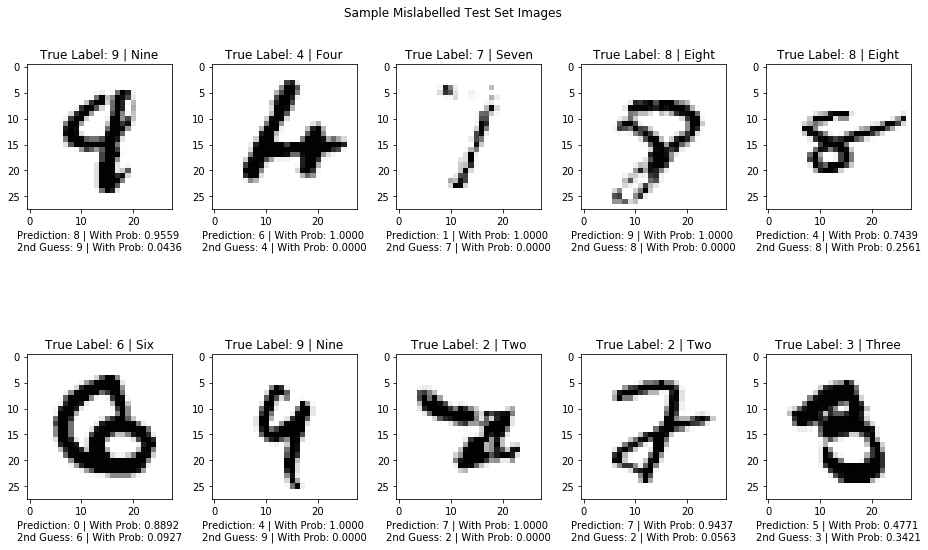

In [41]:
visualize_mislabelled_images(test_x_orig, test_y_orig.T, prediction_test,dataset_type = "test")

### Predicting Real Time images

In [42]:
from PIL import Image

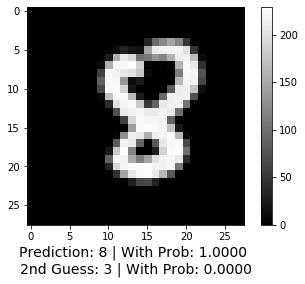

In [43]:
image_name = "8_1.jpg" 

fname = "Sample Images/" + image_name

image_data = np.asarray(Image.open(fname).convert('L').resize((28,28)))
if image_data[1,1] > 250: #if background is white, reversing the fore and background color to match training images
            image_data = 255 - image_data
def predict_real_time(image_data, second_guess = True):
    image_flattened = image_data.reshape(image_data.shape[0]*image_data.shape[1],-1)
    image_norm =(image_flattened/255.)

    prediction = predict(image_norm, params, second_guess = second_guess)
    
    return prediction
    
prediction = predict_real_time(image_data, second_guess = True)

first_lbl, first_prob = prediction["First Prediction"]
sec_lbl, sec_prob = prediction["Second Prediction"]

# plt.title("True Label: "+ str(label.squeeze()))
plt.xlabel("Prediction: %d | With Prob: %.4f \n2nd Guess: %d | With Prob: %.4f"%(first_lbl, first_prob, sec_lbl, sec_prob), fontsize = 14)
plt.imshow(image_data, interpolation ='nearest',cmap='gray')
plt.colorbar()


## Saving and Loading model

In [ ]:
from datetime import date

d = date.today()

path = "Saved Models/"
fname = str(d) + "_Augmented_best_model_test_acc_98-84"

print(fname)

model = {"Parameters": params,
         "Activations": ["relu","relu","softmax"],
## Save the following info if needed
         "Hyper Parameters": hyperParams,
         "initialization":"he",
         "regularizer":"dropout",
         "optimizer":"adam"
        }
save_model(file_name = path+fname, model = model)

In [ ]:
# loading model
path = "Saved Models/"

model = load_model(file_name =path+ "2020-07-21_Augmented_best_model_test_acc_98-84")

loaded_params = model["Parameters"]

In [ ]:
L = len(loaded_params) // 2
print("Total Layers %d: "%L)
for l in range(L):
    print(loaded_params["W" + str(l+1)].shape[0])


## To Do

- [ ] Optimize and refactor the code
- [ ] Prepare the doc String
- [x] add verbose: Integer. 0, 1, 2 or 3. Verbosity mode.
- [ ] Batch norm
- [ ] Maxout
- [ ] Drop Connect
- [x] Data Augmentation if possible